In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                    | 0/60000 [00:00<?, ?it/s]

 12%|██████████▌                                                                           | 7381/60000 [00:00<00:00, 73800.74it/s]

 25%|████████████████████▉                                                                | 14762/60000 [00:00<00:00, 68054.68it/s]

 37%|███████████████████████████████▎                                                     | 22099/60000 [00:00<00:00, 70373.41it/s]

 49%|█████████████████████████████████████████▉                                           | 29616/60000 [00:00<00:00, 72214.48it/s]

 61%|████████████████████████████████████████████████████▏                                | 36859/60000 [00:00<00:00, 71246.51it/s]

 74%|██████████████████████████████████████████████████████████████▊                      | 44328/60000 [00:00<00:00, 72390.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████▍           | 51839/60000 [00:00<00:00, 73263.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▉ | 59262/60000 [00:00<00:00, 73565.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 72145.57it/s]

  0%|                                                                                                    | 0/10000 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████▉                      | 7436/10000 [00:00<00:00, 74350.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 70930.60it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 s6mgguuk


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-s6mgguuk:best, 409.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.8


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                      | 0/368 [00:00<?, ?it/s]

  0%|▎                                                                                             | 1/368 [00:00<03:10,  1.93it/s]

  4%|███▊                                                                                         | 15/368 [00:00<00:11, 31.70it/s]

  8%|███████▌                                                                                     | 30/368 [00:00<00:05, 59.16it/s]

 12%|███████████                                                                                  | 44/368 [00:00<00:04, 79.12it/s]

 16%|██████████████▋                                                                              | 58/368 [00:00<00:03, 94.85it/s]

 20%|██████████████████▎                                                                         | 73/368 [00:01<00:02, 109.19it/s]

 24%|██████████████████████                                                                      | 88/368 [00:01<00:02, 120.14it/s]

 28%|█████████████████████████▏                                                                 | 102/368 [00:01<00:02, 124.58it/s]

 32%|████████████████████████████▋                                                              | 116/368 [00:01<00:01, 128.38it/s]

 36%|████████████████████████████████▍                                                          | 131/368 [00:01<00:01, 132.07it/s]

 40%|████████████████████████████████████                                                       | 146/368 [00:01<00:01, 135.28it/s]

 44%|███████████████████████████████████████▊                                                   | 161/368 [00:01<00:01, 137.53it/s]

 48%|███████████████████████████████████████████▌                                               | 176/368 [00:01<00:01, 139.27it/s]

 52%|███████████████████████████████████████████████▏                                           | 191/368 [00:01<00:01, 140.62it/s]

 56%|██████████████████████████████████████████████████▉                                        | 206/368 [00:01<00:01, 141.24it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 221/368 [00:02<00:01, 141.63it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 236/368 [00:02<00:00, 142.08it/s]

 68%|██████████████████████████████████████████████████████████████                             | 251/368 [00:02<00:00, 142.25it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 266/368 [00:02<00:00, 142.51it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 281/368 [00:02<00:00, 142.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 296/368 [00:02<00:00, 142.63it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 311/368 [00:02<00:00, 142.68it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 326/368 [00:02<00:00, 142.66it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 341/368 [00:02<00:00, 142.71it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 356/368 [00:03<00:00, 142.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:03<00:00, 116.52it/s]

train - OK


  0%|                                                                                                       | 0/92 [00:00<?, ?it/s]

  7%|██████▏                                                                                        | 6/92 [00:00<00:01, 57.61it/s]

 22%|████████████████████▏                                                                        | 20/92 [00:00<00:00, 103.26it/s]

 37%|██████████████████████████████████▎                                                          | 34/92 [00:00<00:00, 118.26it/s]

 52%|████████████████████████████████████████████████▌                                            | 48/92 [00:00<00:00, 125.73it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 62/92 [00:00<00:00, 130.07it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 76/92 [00:00<00:00, 132.14it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 90/92 [00:00<00:00, 134.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 116.40it/s]

val - OK


  0%|                                                                                                       | 0/76 [00:00<?, ?it/s]

  8%|███████▌                                                                                       | 6/76 [00:00<00:01, 58.25it/s]

 26%|████████████████████████▍                                                                    | 20/76 [00:00<00:00, 104.27it/s]

 45%|█████████████████████████████████████████▌                                                   | 34/76 [00:00<00:00, 119.02it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 48/76 [00:00<00:00, 126.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 62/76 [00:00<00:00, 130.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 117.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 112.87it/s]

test InD - OK


  0%|                                                                                                      | 0/559 [00:00<?, ?it/s]

  1%|█                                                                                             | 6/559 [00:00<00:09, 56.10it/s]

  4%|███▍                                                                                        | 21/559 [00:00<00:05, 106.22it/s]

  6%|█████▉                                                                                      | 36/559 [00:00<00:04, 122.34it/s]

  9%|████████▍                                                                                   | 51/559 [00:00<00:03, 130.19it/s]

 12%|██████████▊                                                                                 | 66/559 [00:00<00:03, 134.30it/s]

 14%|█████████████▎                                                                              | 81/559 [00:00<00:03, 136.42it/s]

 17%|███████████████▊                                                                            | 96/559 [00:00<00:03, 137.95it/s]

 20%|██████████████████                                                                         | 111/559 [00:00<00:03, 139.00it/s]

 23%|████████████████████▌                                                                      | 126/559 [00:00<00:03, 139.87it/s]

 25%|██████████████████████▉                                                                    | 141/559 [00:01<00:02, 140.50it/s]

 28%|█████████████████████████▍                                                                 | 156/559 [00:01<00:02, 140.95it/s]

 31%|███████████████████████████▊                                                               | 171/559 [00:01<00:02, 140.91it/s]

 33%|██████████████████████████████▎                                                            | 186/559 [00:01<00:02, 139.93it/s]

 36%|████████████████████████████████▌                                                          | 200/559 [00:01<00:02, 138.87it/s]

 38%|██████████████████████████████████▊                                                        | 214/559 [00:01<00:02, 138.98it/s]

 41%|█████████████████████████████████████                                                      | 228/559 [00:01<00:02, 138.67it/s]

 43%|███████████████████████████████████████▌                                                   | 243/559 [00:01<00:02, 139.42it/s]

 46%|█████████████████████████████████████████▊                                                 | 257/559 [00:01<00:02, 139.36it/s]

 48%|████████████████████████████████████████████                                               | 271/559 [00:01<00:02, 139.22it/s]

 51%|██████████████████████████████████████████████▍                                            | 285/559 [00:02<00:01, 139.11it/s]

 53%|████████████████████████████████████████████████▋                                          | 299/559 [00:02<00:01, 139.26it/s]

 56%|██████████████████████████████████████████████████▉                                        | 313/559 [00:02<00:01, 139.17it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 327/559 [00:02<00:01, 139.13it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 341/559 [00:02<00:01, 139.12it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 355/559 [00:02<00:01, 138.50it/s]

 66%|████████████████████████████████████████████████████████████                               | 369/559 [00:02<00:01, 138.80it/s]

 69%|██████████████████████████████████████████████████████████████▎                            | 383/559 [00:02<00:01, 138.94it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 397/559 [00:02<00:01, 138.77it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 411/559 [00:03<00:01, 138.83it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 425/559 [00:03<00:00, 139.17it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                   | 439/559 [00:03<00:00, 139.32it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 453/559 [00:03<00:00, 139.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 468/559 [00:03<00:00, 139.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 482/559 [00:03<00:00, 139.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 497/559 [00:03<00:00, 139.94it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 511/559 [00:03<00:00, 139.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 526/559 [00:03<00:00, 140.31it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 541/559 [00:03<00:00, 139.35it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 555/559 [00:04<00:00, 139.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:04<00:00, 135.52it/s]

test OoD - OK


  0%|                                                                                                      | 0/100 [00:00<?, ?it/s]

 15%|█████████████▊                                                                              | 15/100 [00:00<00:00, 142.04it/s]

 30%|███████████████████████████▌                                                                | 30/100 [00:00<00:00, 142.56it/s]

 45%|█████████████████████████████████████████▍                                                  | 45/100 [00:00<00:00, 142.70it/s]

 60%|███████████████████████████████████████████████████████▏                                    | 60/100 [00:00<00:00, 142.53it/s]

 75%|█████████████████████████████████████████████████████████████████████                       | 75/100 [00:00<00:00, 142.42it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 90/100 [00:00<00:00, 142.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 142.38it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(23523, 3, 32, 32) (23523, 2048) (23523, 256) (23523, 5) (23523,)
(5881, 3, 32, 32) (5881, 2048) (5881, 256) (5881, 5) (5881,)
(4861, 3, 32, 32) (4861, 2048) (4861, 256) (4861, 5) (4861,)
(35735, 3, 32, 32) (35735, 2048) (35735, 256) (35735, 5) (35735,)
(6400, 3, 32, 32) (6400, 2048) (6400, 256) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(4861, 2) (35735, 2)


(4861, 2) (35735, 2)


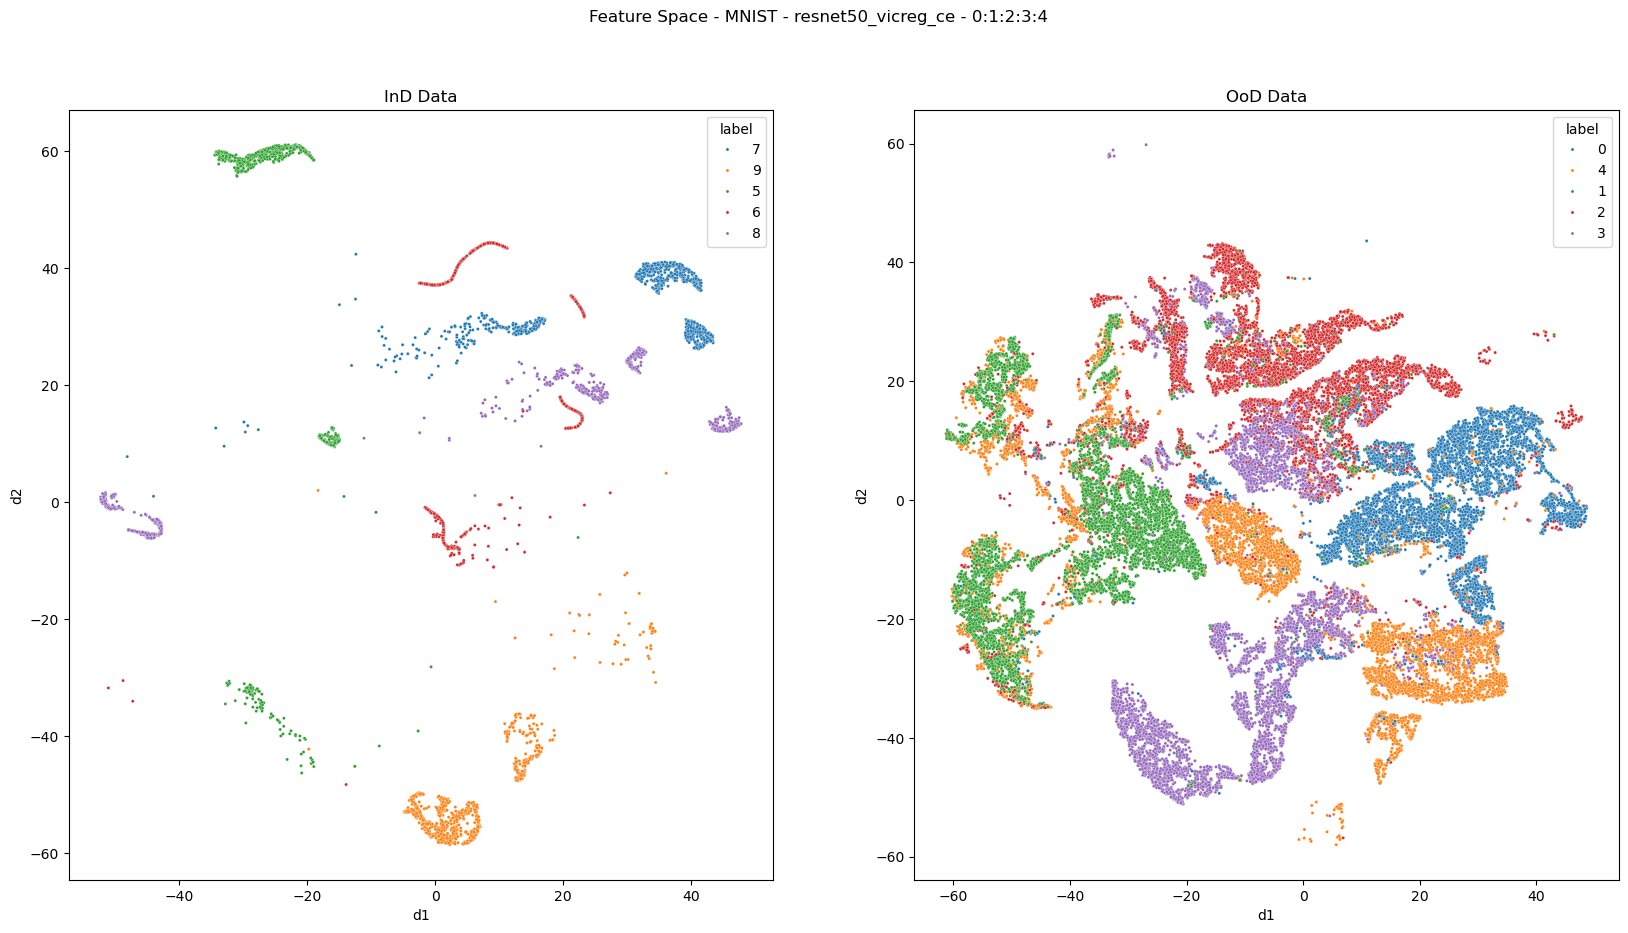

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

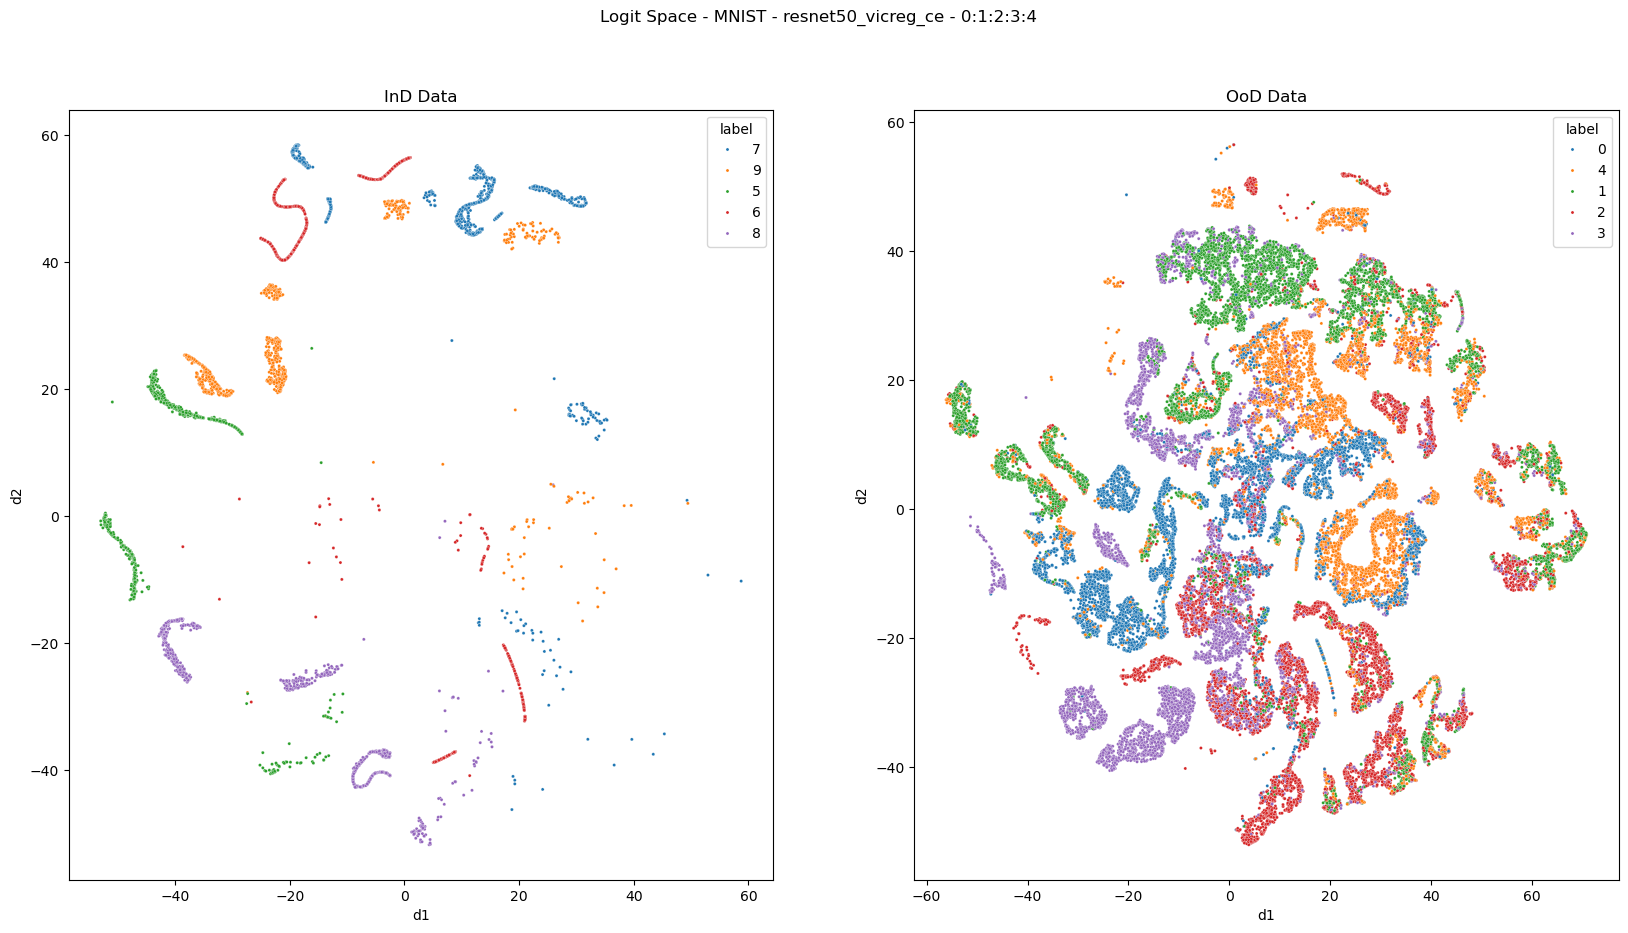

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:06<00:19,  6.38s/it]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:12<00:12,  6.50s/it]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:19<00:06,  6.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.56s/it]

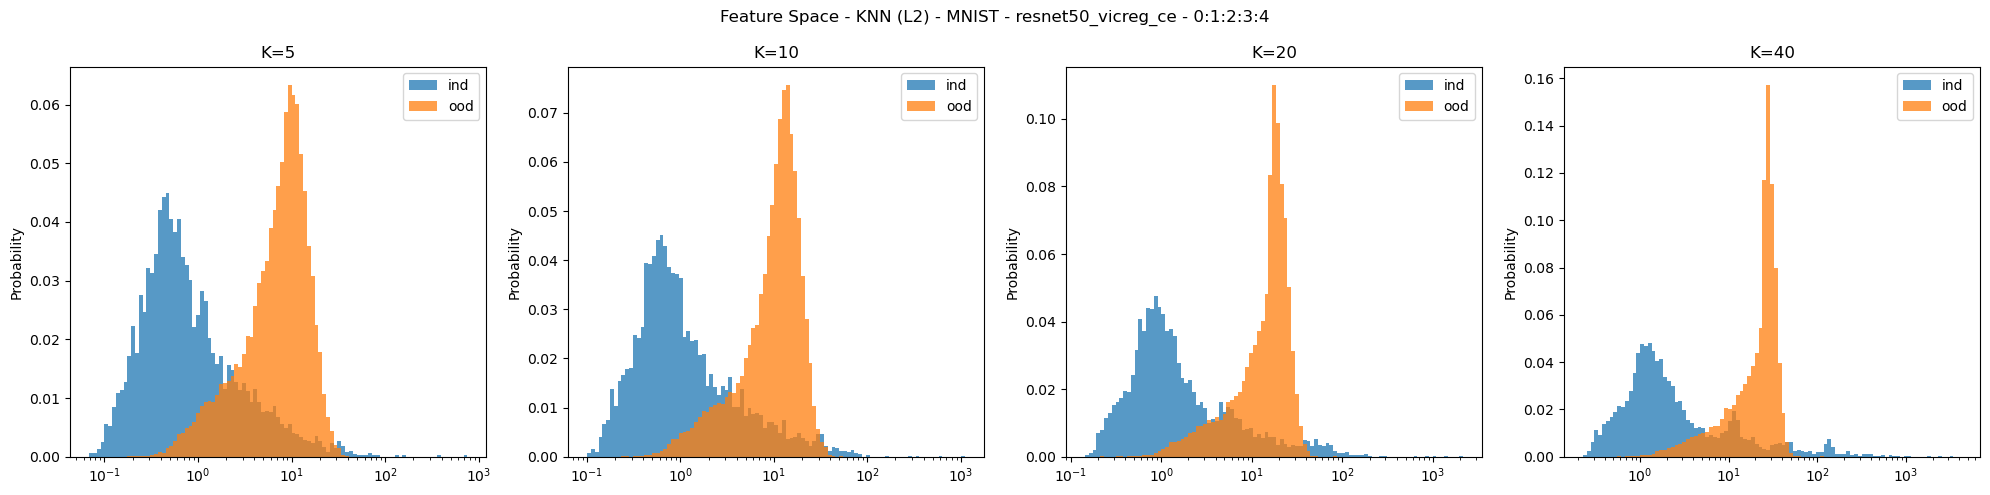

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:06<00:19,  6.51s/it]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:12<00:12,  6.42s/it]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:19<00:06,  6.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.53s/it]

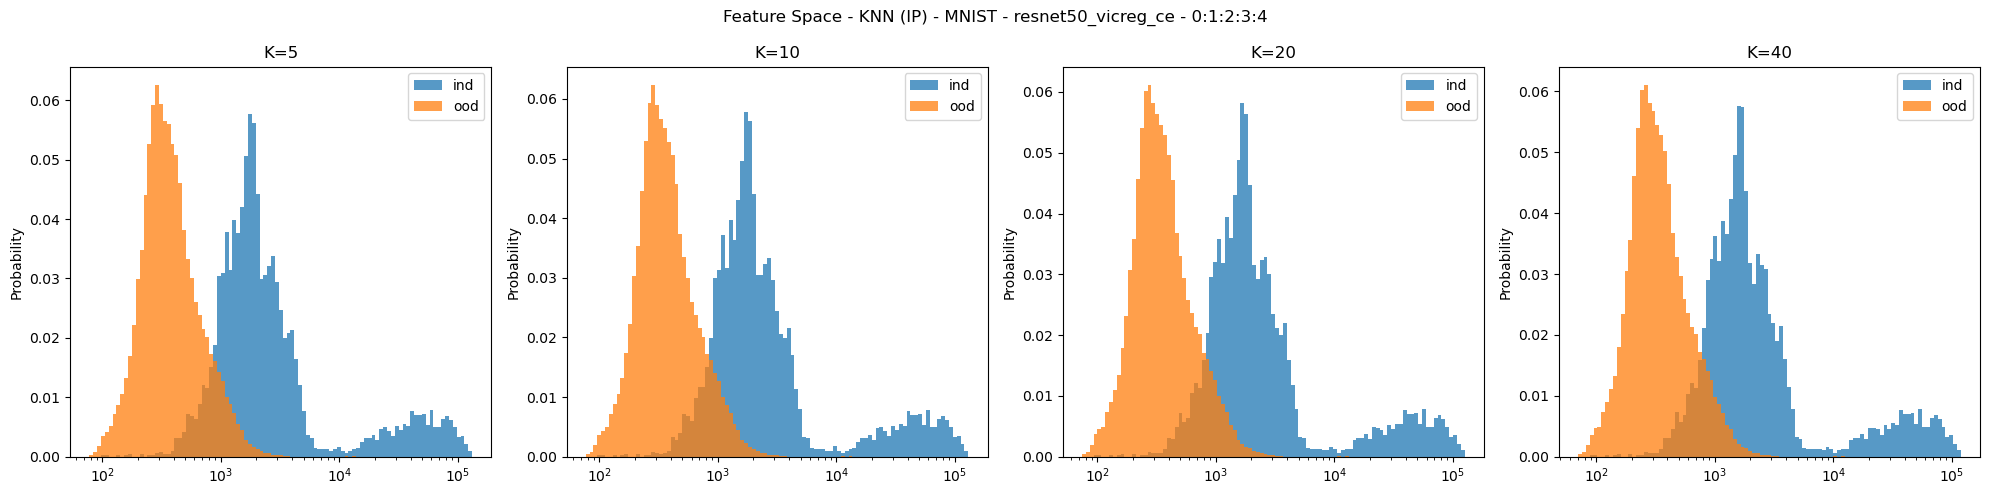

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:00<00:01,  2.72it/s]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:00<00:00,  2.57it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:01<00:00,  2.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]

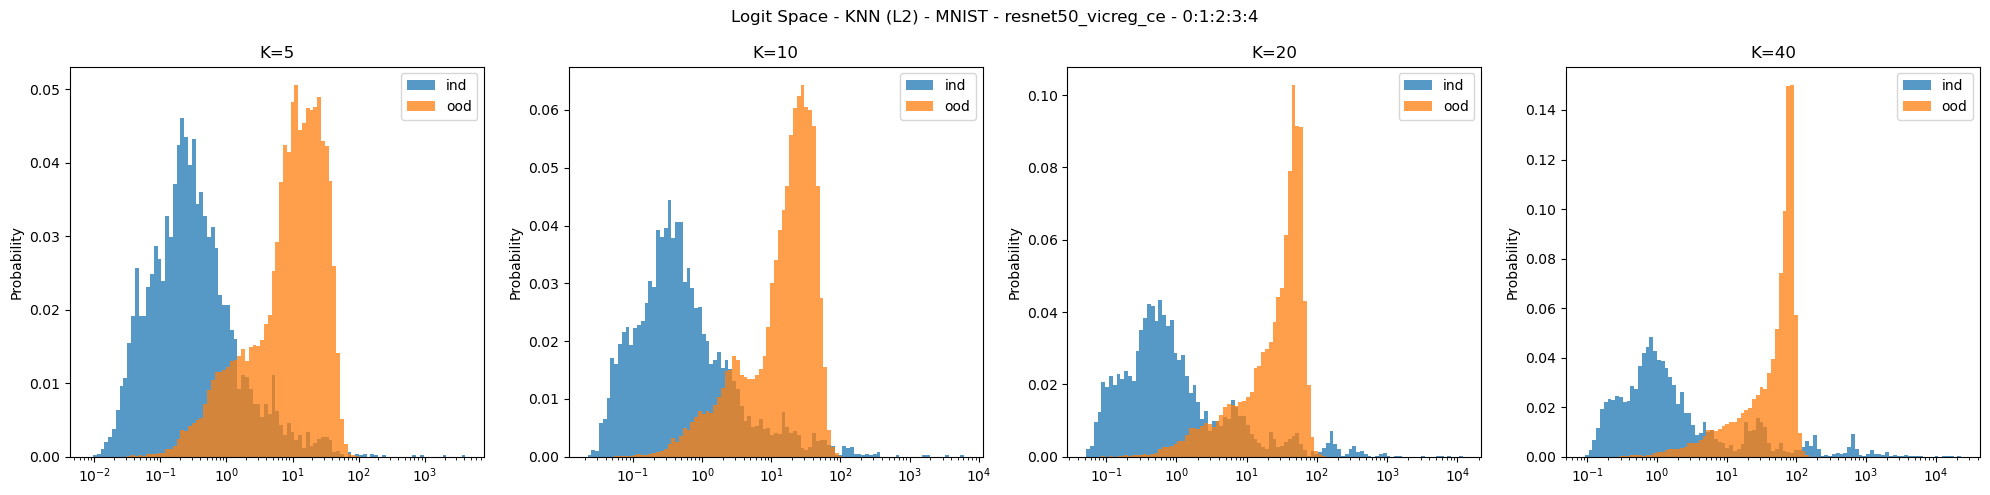

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:00<00:01,  2.99it/s]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:00<00:00,  2.83it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:01<00:00,  2.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]

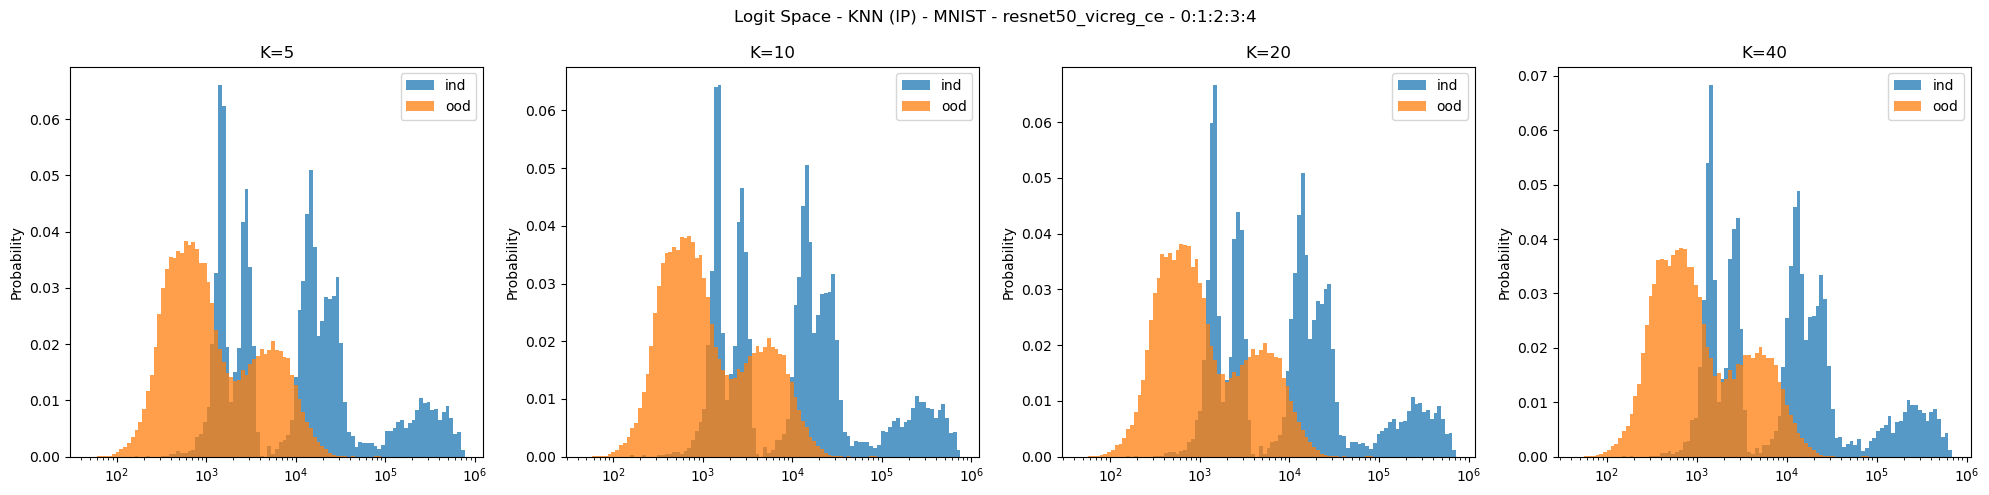

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_640569/3659132256.py:1: RuntimeWarning: overflow encountered in exp
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_640569/3659132256.py:1: RuntimeWarning: invalid value encountered in divide
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_640569/3659132256.py:6: RuntimeWarning: overflow encountered in exp
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_640569/3659132256.py:6: RuntimeWarning: invalid value encountered in divide
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)


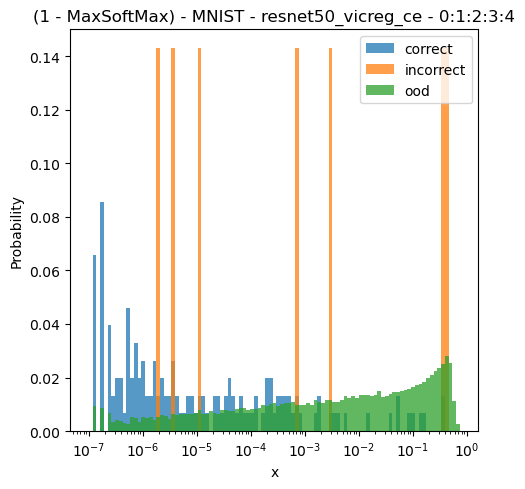

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()